### Support Vector Machine (SVM) Classifier

This analysis shows the basic steps for training, evaluating, and tuning an SVM classifier.

### Data Pre-Processing and Exploration

In [1]:
# Load modules
import pandas as pd
from sklearn import datasets

# Load breast cancer dataset
cancer = datasets.load_breast_cancer()
X, y = datasets.load_breast_cancer(return_X_y=True)

# Get familiar with the dataset - features, labels, etc.
print("Features: ", cancer.feature_names)
print("Target Names: ", cancer.target_names)
print("Target Labels: ", set(cancer.target)) # 0 = benign, 1 = malignant

# Assess class imbalance
for label, count in pd.Series(cancer.target).value_counts().sort_index().items():
    percentage = (count / len(cancer.target)) * 100
    print(f"Class {label} ({cancer.target_names[label]}): {percentage:.2f}%")

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data,
    cancer.target,
    test_size=0.2, # 80/20 train/test split
    random_state=113 # for reproducibility
)

Features:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target Names:  ['malignant' 'benign']
Target Labels:  {np.int64(0), np.int64(1)}
Class 0 (malignant): 37.26%
Class 1 (benign): 62.74%


### Visualize Feature Distributions

- Determine whether there are any outliers, strongly skewed features, etc.
- This step is feasible, given there are only a few features in the model.
- A dataset with many more features could use an automated feature selection step to subset to a few features for exploration.

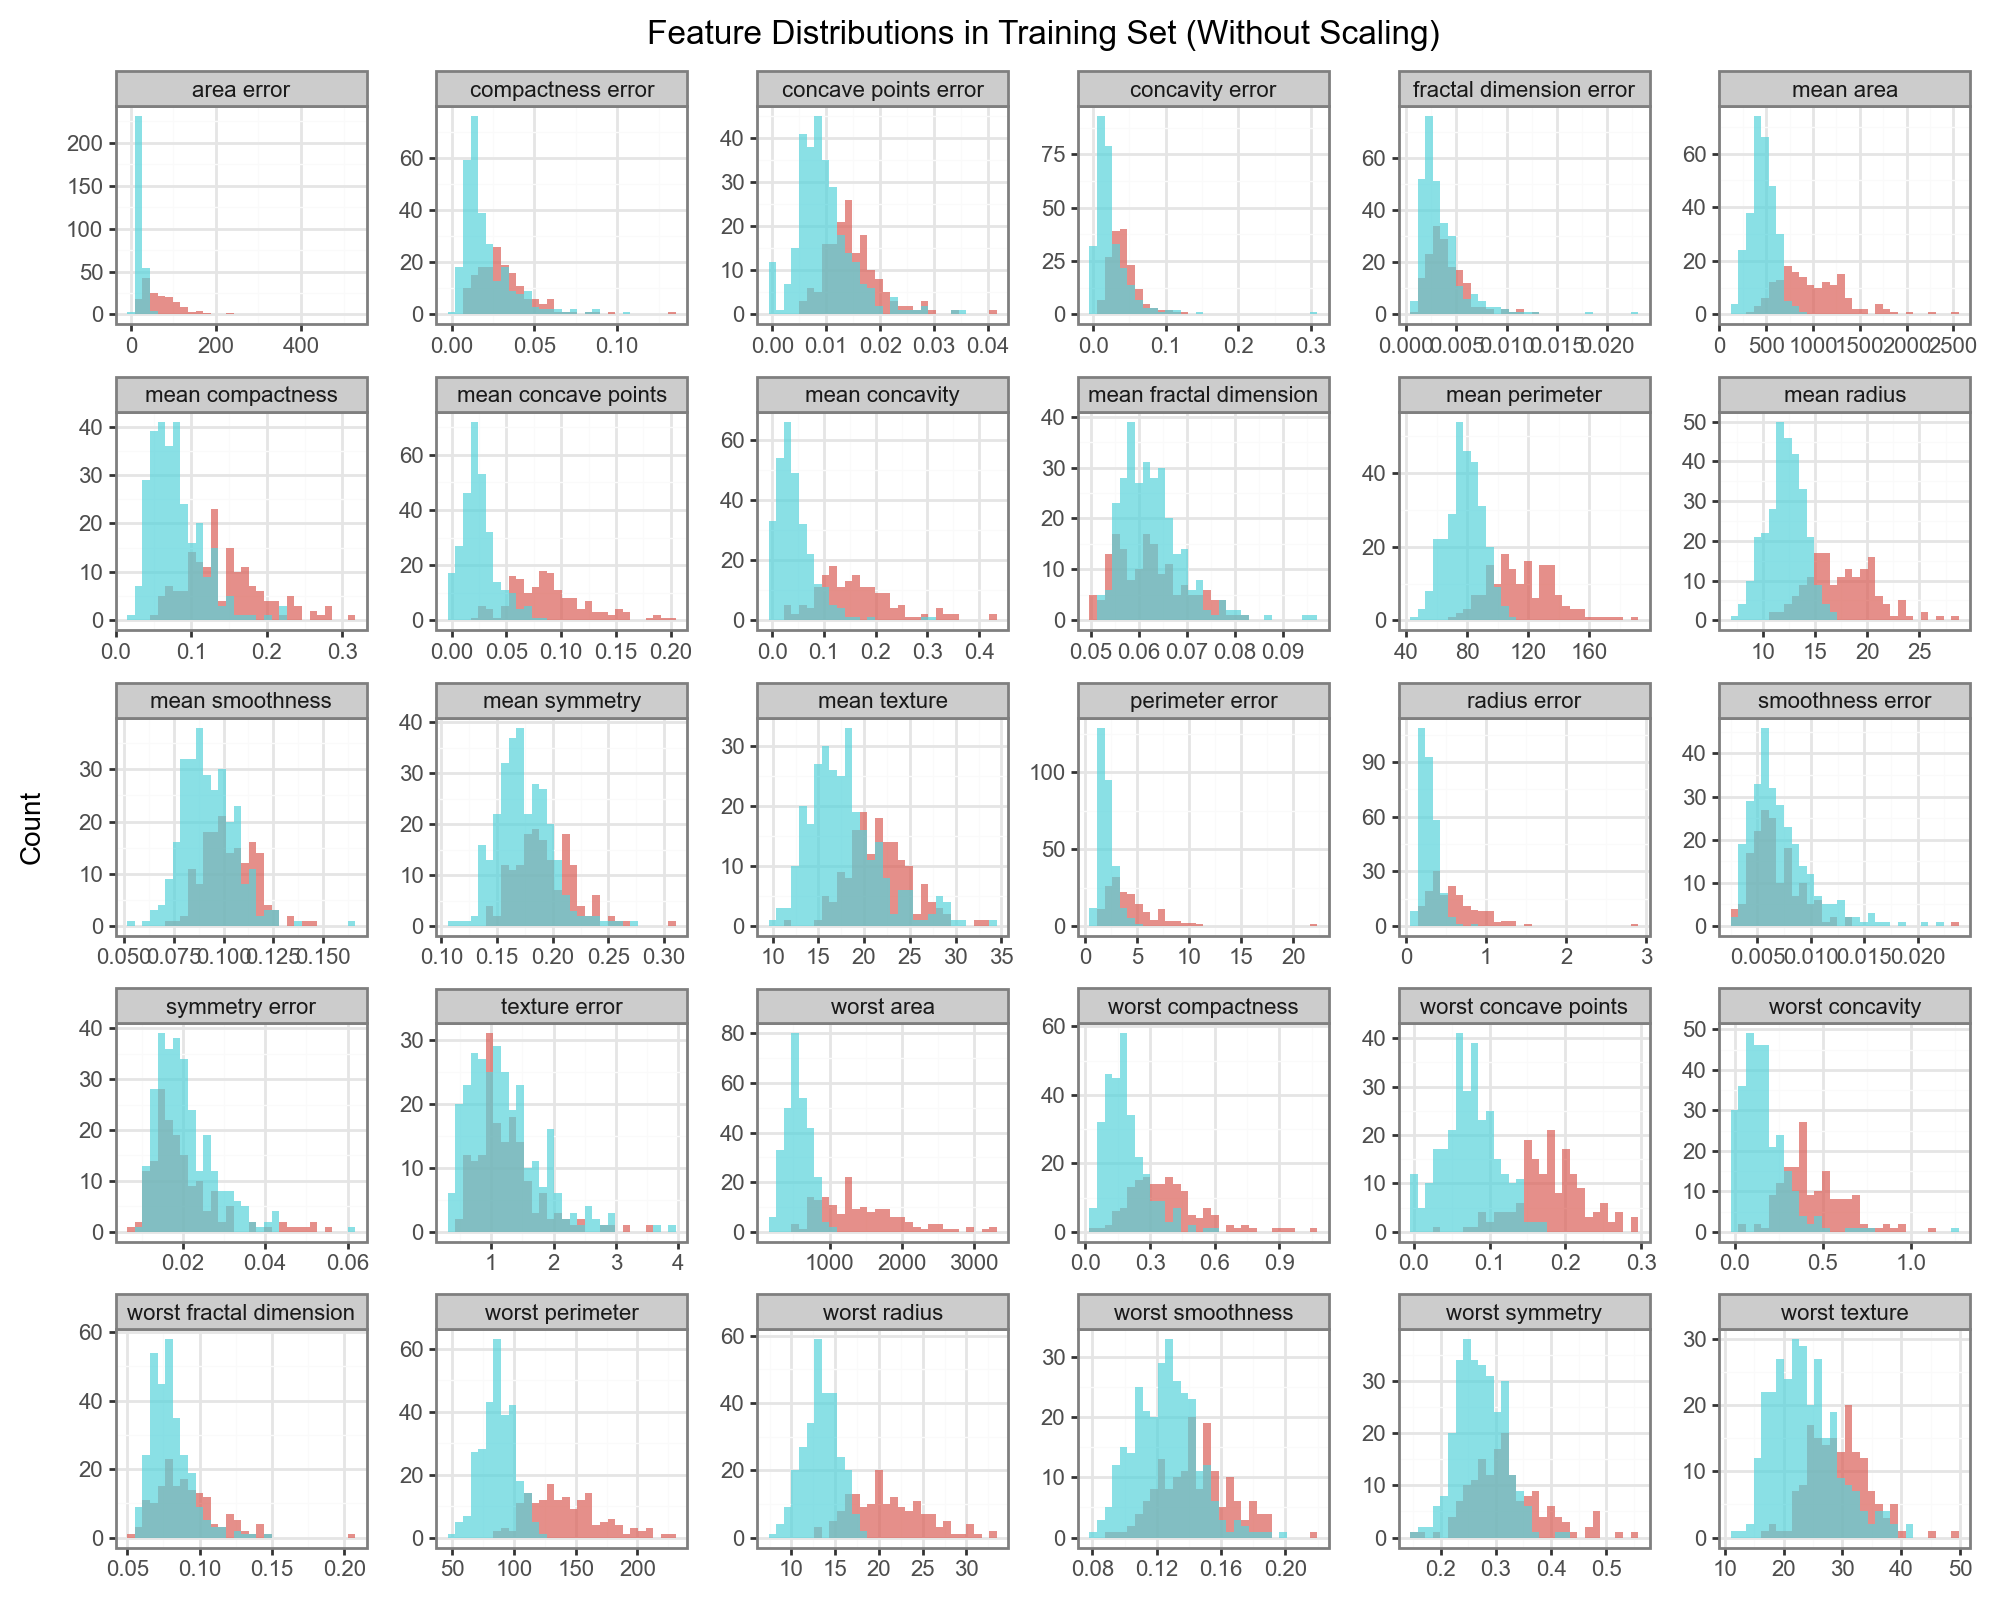

In [2]:
# Import modules for visualization
import pandas as pd
import plotnine as plt

# Convert to pd DataFrame for easier plotting
df_train = pd.DataFrame(X_train, columns=cancer.feature_names)
df_train['target'] = y_train

# Plot the distribution of features for each target class (red - malignant, blue - benign)
plot = (plt.ggplot(df_train.melt(id_vars='target'), plt.aes(x='value')) +
        plt.aes(fill='factor(target)') +
    plt.geom_histogram(bins=30, alpha=0.7, position='identity') +
    plt.facet_wrap('~variable', scales='free') +
    plt.labs(title='Feature Distributions in Training Set (Without Scaling)', x='', y='Count') +
    # Customize theme
    plt.theme_bw(base_family = "Arial", base_size = 10) +
    plt.theme(figure_size=(10, 8)) +
    plt.theme(legend_position='none')
)

# Display plot
display(plot)

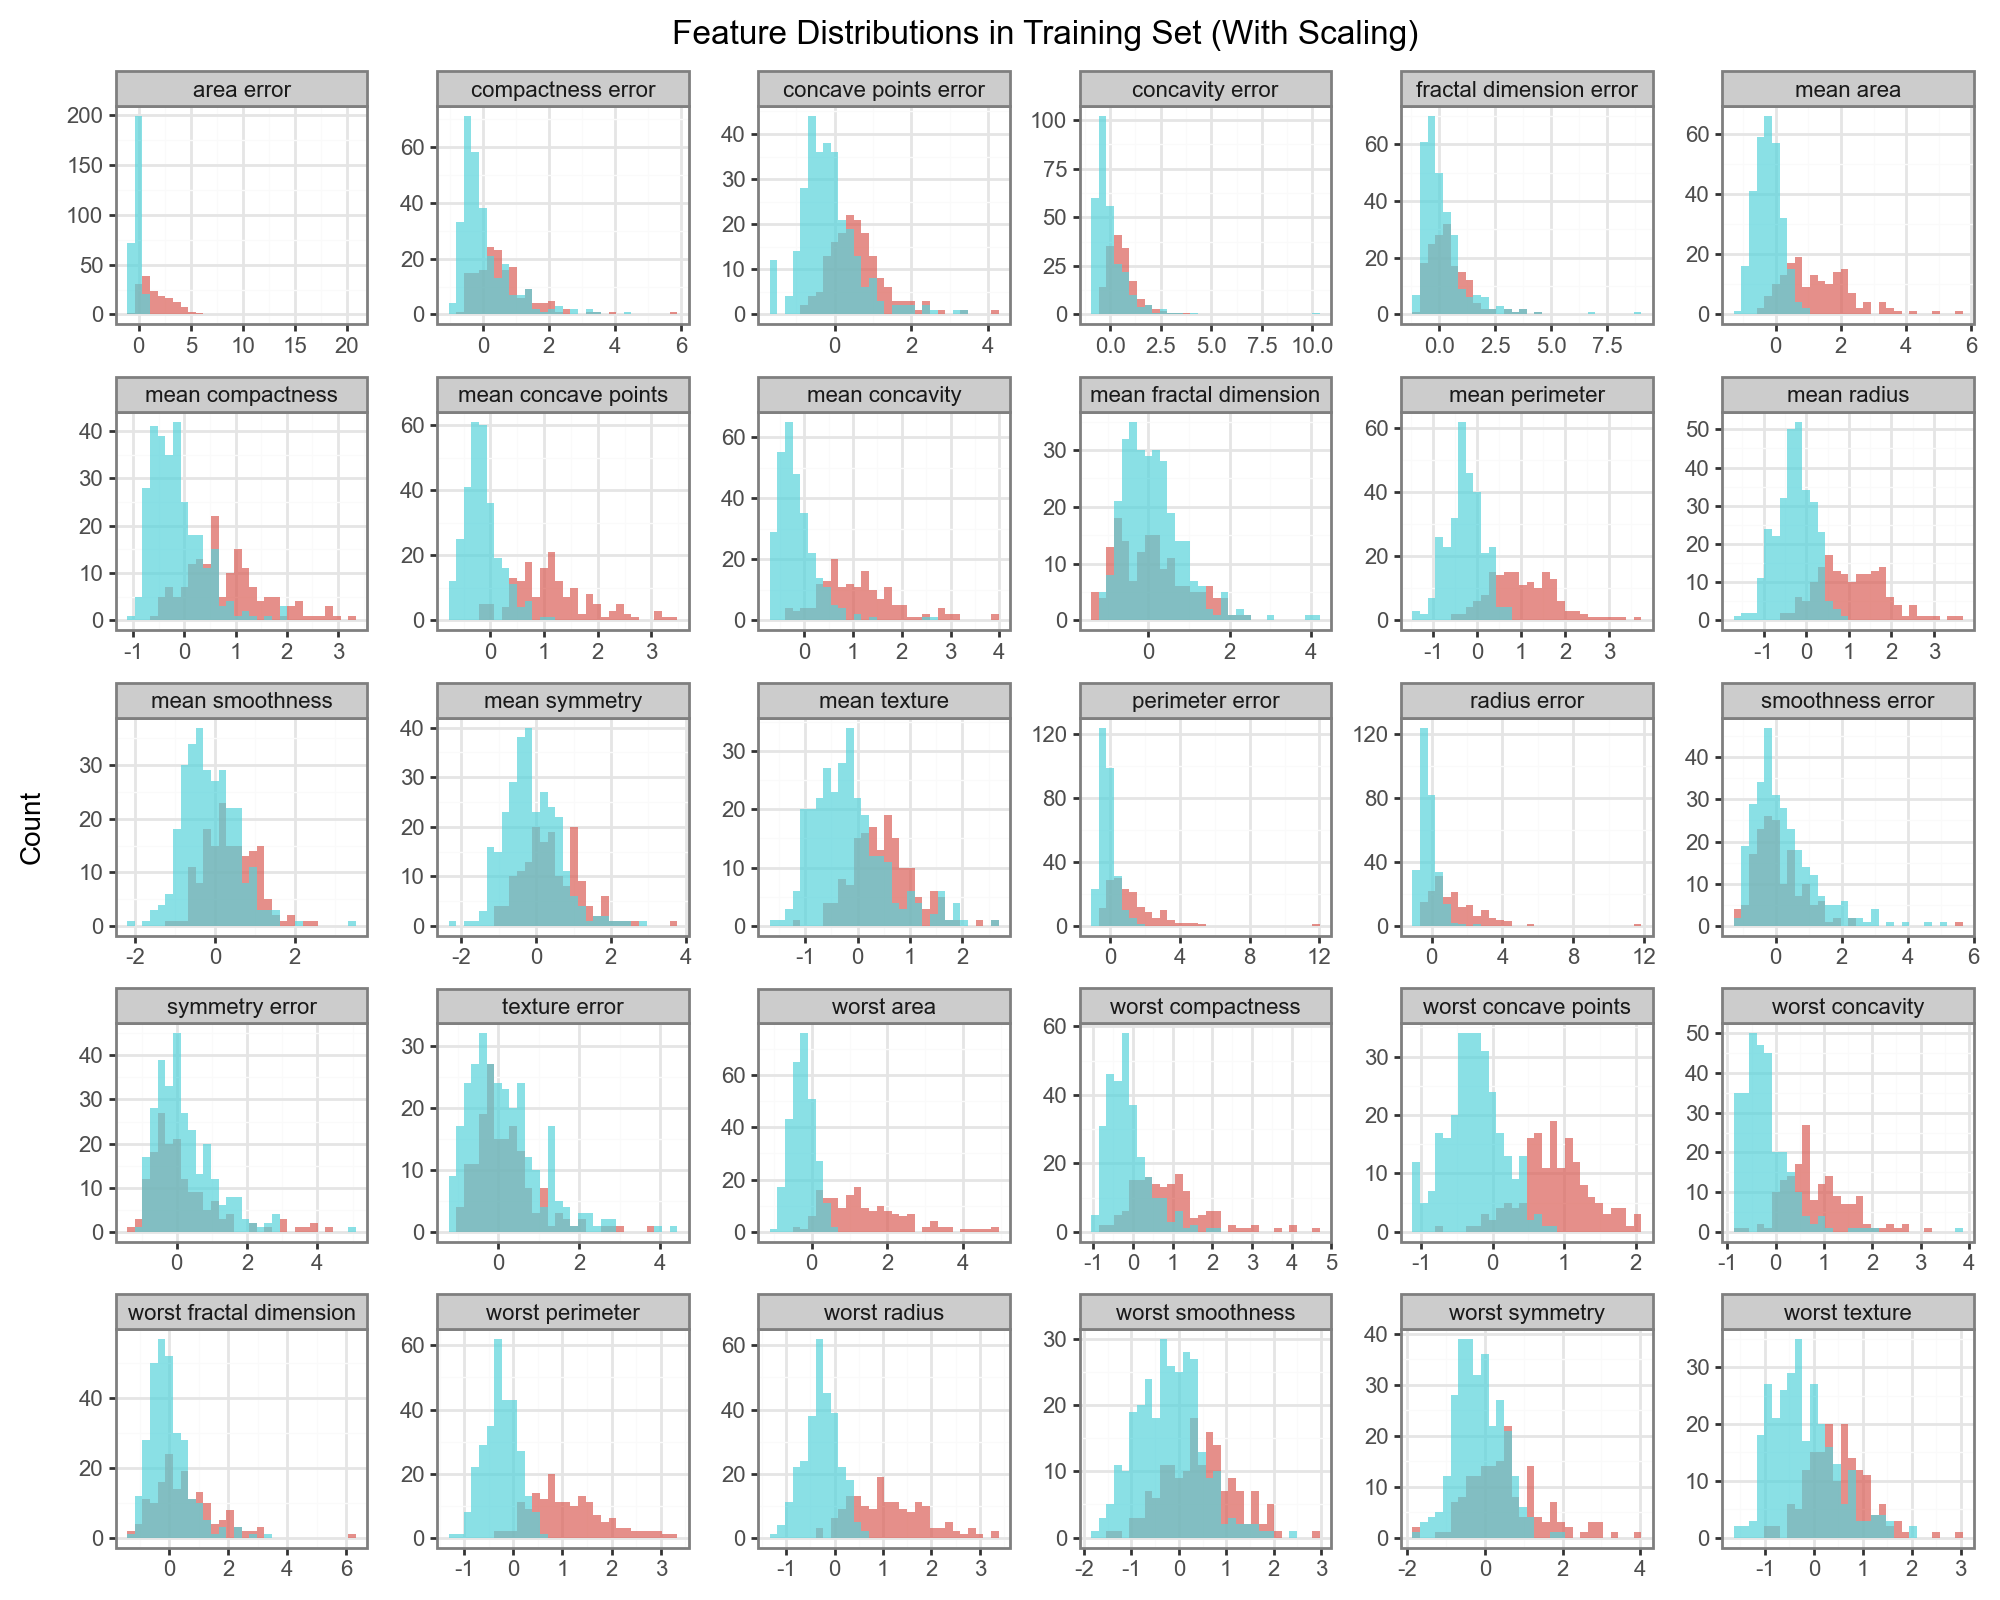

In [3]:
# Scale features for X_train, X_test
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Repeat the above visualization, using the scaled data
df_train = pd.DataFrame(X_train, columns=cancer.feature_names)
df_train['target'] = y_train

# Plot the distribution of features for each target class (red - malignant, blue - benign)
plot = (plt.ggplot(df_train.melt(id_vars='target'), plt.aes(x='value')) +
        plt.aes(fill='factor(target)') +
    plt.geom_histogram(bins=30, alpha=0.7, position='identity') +
    plt.facet_wrap('~variable', scales='free') +
    plt.labs(title='Feature Distributions in Training Set (With Scaling)', x='', y='Count') +
    # Customize theme
    plt.theme_bw(base_family = "Arial", base_size = 10) +
    plt.theme(figure_size=(10, 8)) +
    plt.theme(legend_position='none')
)

# Display plot
display(plot)

### Train and Evaluate Baseline Model

- Run an SVM model with default hyperparameters as a baseline. (See hyperparameter tuning, below.)
- Assess model performance (accuracy, precision, recall) on the withheld test set.
- **Accuracy:** The model predicts the correct outcome X% of the time, overall.
- **Precision:** Of the samples that were predicted malignant, X% were *actually* malignant.
- **Recall:** Of the samples that were *actually* malignant, the model accurately predicted X%.

In [4]:
# Import SVM model from sklearn
from sklearn import svm
clf = svm.SVC(random_state=113) # for reproducibility

# Train on the training data and predict on the test data
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Display results   
from sklearn import metrics
print("Results for SVM Classifier, evaluated on test set:")
print("Accuracy: {:.0f} %".format(metrics.accuracy_score(y_test, y_pred)*100))
print("Precision: {:.0f} %".format(metrics.precision_score(y_test, y_pred)*100))
print("Recall: {:.0f} %".format(metrics.recall_score(y_test, y_pred)*100))

Results for SVM Classifier, evaluated on test set:
Accuracy: 96 %
Precision: 95 %
Recall: 97 %


Summary: This model shows excellent generalization from the training data (96% accuracy for the test set) and consistent performance across all metrics (accuracy, precision, and recall).

### Perform K-Fold Cross-Validation

- To evaluate model performance more thoroughly, use k-fold cross-validation. (See [sklearn documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)).
- For each k-fold, the model trains on (k-1) folds of the training data and is validated on the remainder.
- Accuracy, precision, and recall (detailed above) are now *averages* of those values, calculated per CV loop.


In [7]:
# Import cross-validation module from sklearn
from sklearn.model_selection import cross_val_score

# Calculate accuracy, precision, and recall
accuracy_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
precision_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
recall_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')

# Display results
print("Results for SVM Classifier, evaluated via 5-fold cross-validation:")
print("Average Accuracy: {:.1f} %".format(accuracy_scores.mean()*100))
print("Average Precision: {:.1f} %".format(precision_scores.mean()*100))
print("Average Recall: {:.1f} %".format(recall_scores.mean()*100))

Results for SVM Classifier, evaluated via 5-fold cross-validation:
Average Accuracy: 98.0 %
Average Precision: 98.0 %
Average Recall: 99.0 %


Summary: CV metrics are on par with the above test metrics. This is good! If a model has high CV accuracy but much lower test accuracy, then the model is likely over-fitting to the training data. (A model that "memorizes" the training data will not generalize well to new, unseen data.)

### Tuning Hyperparameters (Exploratory)

- The baseline model already performs well, but tuning hyperparameters may deliver some small gains.
- SVM hyperparameters include:
- kernel: transforms the data input into the required form (linear, poly, etc.).
- regularization (C): represents the error term (i.e. the size of the hyperplane margin)
- gamma: determines how closely to fit to the training data (lower = looser fit; beware over-fitting!)